# DSC-037 step 4: Compute delay power spectra


---

**DSC-037**: Cable reflection systematics for EoR science

**Author:** Adélie Gorce and Teal team 

**Documentation on confluence:** 
- DSC description page: https://confluence.skatelescope.org/x/0rs6F
- Chronological walkthrough: https://confluence.skatelescope.org/x/osw6F
- Implementation: https://confluence.skatelescope.org/x/n8LMF
- GitHub repo: https://github.com/uksrc-developers/dsc-037-eor

**Summary:**  This notebook is a first implementation of the step 4 of DSC-037 (see chronological walkthrough above) to calculate delay power spectra for individual baselines and then cylindrically averaged power spectra for a user-specified set of frequencies, times, and polarisations.
In this notebook, we
- Load the visibilities
- Compute a delay power spectrum for a single baseline using the `pyuvdata` and `hera_pspec` packages


**Ticket:** TEAL-1129 https://jira.skatelescope.org/browse/TEAL-1129


**Data:**
We use the MWA dataset available on Rucio (https://confluence.skatelescope.org/x/tnTGEg) as a proxy for DV AA2 data. The dataset has the following structure:
- Integration time: 8s
- Total time: 112s
- Bandwidth: 28MHz
- Central frequency: 65 MHz
- Number of channels: 384
- Channel width: 44 kHz
- Processing applied: DI-calibration and sky model subtraction
- Calibration solutions available
- Size: 1.9 GB




In [ ]:
# import required packages
import numpy as np
from astropy import units, constants
import time
import matplotlib.pyplot as plt

In [49]:
import hera_pspec as hp
import pyuvdata

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Inspect dataset

In [6]:
datafolder = './'  # where to find the downloaded data

In [7]:
datafile = 'hyp_1184702048_ionosub_ssins_30l_src8k_300it_8s_80kHz_i1000.uvfits'

Load the metadata to inspect global dataset

In [9]:
uvd_meta = pyuvdata.UVData()
uvd_meta.read_uvfits(datafile, read_data=False)

In [50]:
print(f'Number of baselines: {uvd_meta.Nbls}')
print(f'Number of times: {uvd_meta.Ntimes}')
print(f'Number of frequencies: {uvd_meta.Nfreqs}')
print(f'Number of polarizations: {uvd_meta.Npols} ({uvd_meta.polarization_array})')

Number of baselines: 7381
Number of times: 14
Number of frequencies: 384
Number of polarizations: 4 ([-5 -6 -7 -8])


Pick a single antenna-pair (baseline) - and polarisation channel - to look at

In [68]:
# select one baseline to work with
antpairs = uvd_meta.get_antpairs()[46]

In [ ]:
uvd_meta.get_antpairs()[478], uvd_meta.get_antpairs()[478]

(5, 6)

In [69]:
# select polarization channel
pol = uvd_meta.polarization_array[0]

In [70]:
# load data for that baseline and polarization
uvd_1bl = pyuvdata.UVData()
uvd_1bl.read_uvfits(datafile, antenna_nums=antpairs, polarizations=[pol])
dat = np.copy(uvd_1bl.data_array[..., 0])

Waterfall plot:

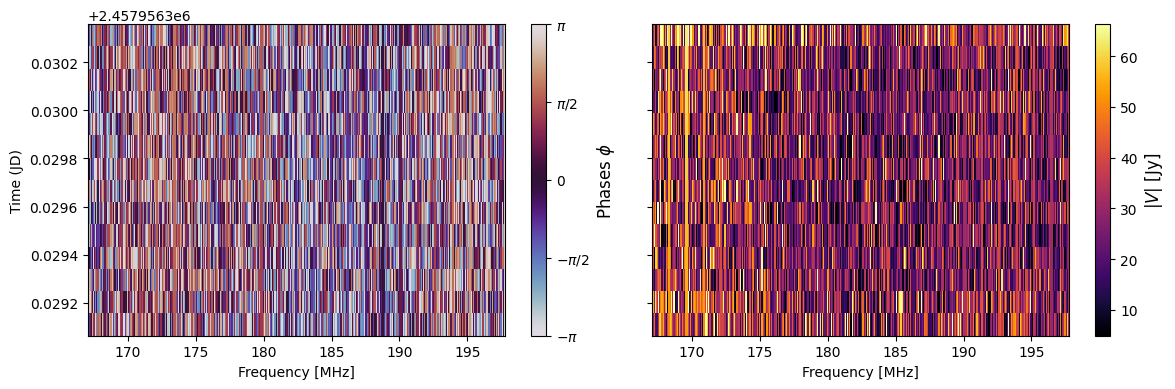

In [ ]:
# plot
vmin = np.percentile(abs(dat), 2)
vmax = np.percentile(abs(dat), 98)

fig, ax = plt.subplots(1,2,figsize=(6*2,4), sharey=True)

#phases
im = ax[0].pcolormesh(
    uvd_1bl.freq_array/1e6,
    uvd_1bl.time_array,
	np.angle(dat),
	vmin=-np.pi, vmax=np.pi, 
	cmap='twilight'
)
cbar = fig.colorbar(im, ax = ax[0], ticks=[-np.pi,-np.pi/2,0.,np.pi/2,np.pi])
cbar.set_label(r'Phases $\phi$', fontsize=12)
cbar.ax.set_yticklabels([r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$']) 

#amplitude
im = ax[1].pcolormesh(
    uvd_1bl.freq_array/1e6,
    uvd_1bl.time_array,
	np.abs(dat), 
	vmin=vmin, vmax=vmax,
	cmap='inferno'
)
cbar = fig.colorbar(im, ax = ax[1])
cbar.set_label(r'$\vert V \vert$ [Jy]', fontsize=12)
for a in ax:
	a.set_xlabel('Frequency [MHz]')
ax[0].set_ylabel('Time (JD)')
plt.tight_layout()

## Construct the delay power spectrum for an auto-baseline

In [66]:
# for now, no beam
uvb = None

In [105]:
# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd_1bl, uvd_1bl], wgts=[None, None], beam=uvb)
# ds.rephase_to_dset(0)
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [106]:
baselines = [antpairs]

In [107]:
t0 = time.time()
uvp = ds.pspec(
    baselines, baselines,
    dsets=(0, 1), 
    pols=[(pol, pol)],
    spw_ranges=[(100, 200)],  # select a smaller bandwidth
    verbose=True
)
t1 = time.time()
print(f'Time required to compute the delay power spectrum for one baseline pair: {(t1-t0)/60.:.1} minutes.')

 which may lead to normalization instabilities.
Time required to compute the delay power spectrum for one baseline pair: 0.009 minutes.


Compute the time average of the spectrum

In [112]:
uvp_time_avg = uvp.average_spectra(time_avg=True, inplace=False)

Plot results

In [108]:
# Choose spectral window
spw = 0

Text(0, 0.5, 'Delay spectrum')

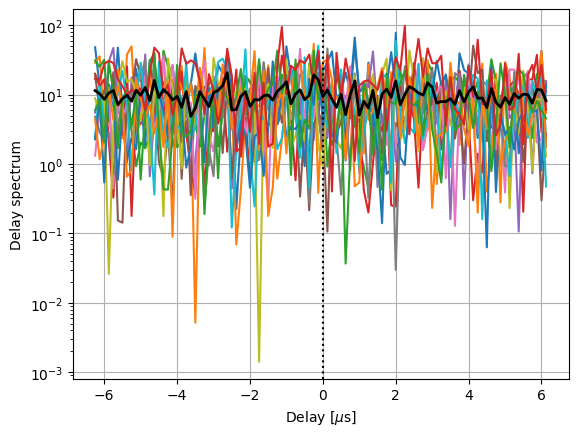

In [ ]:
plt.figure(figsize=(12, 5))
plt.grid()
for i in range(uvp.Ntimes):
    plt.semilogy(uvp.dly_array*1e6, uvp.data_array[spw][i, :, 0].real, lw=.8)
plt.semilogy(uvp.dly_array*1e6, uvp_time_avg.data_array[spw][0, :, 0].real, color='k', lw=2, label='Time average')
plt.axvline(0, color='k', ls=':')
plt.xlabel(r'Delay [$\mu$s]')
plt.ylabel('Delay spectrum')

## Compute the delay power spectrum for a baseline pair

Select redundant baselines

In [191]:
# get redundant baselines
reds, lens, angs = hp.utils.get_reds(uvd_meta, pick_data_ants=True)
# choose a redundant group
ired = 4
baselines = reds[ired][:2]
# get baseline-pairs
bls1, bls2, blps = hp.utils.construct_blpairs(baselines, exclude_auto_bls=True, exclude_permutations=True)


In [192]:
# load data for that baseline and polarization
uvd_2bl = pyuvdata.UVData()
uvd_2bl.read_uvfits(datafile, antenna_nums=baselines, polarizations=[pol])
dat = np.copy(uvd_2bl.data_array[..., 0])

In [193]:
# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd_2bl, uvd_2bl], wgts=[None, None], beam=uvb)
# ds.rephase_to_dset(0)
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [194]:
t0 = time.time()
uvp = ds.pspec(
    bls1, bls2,
    dsets=(0, 1), 
    pols=[(pol, pol)],
    spw_ranges=[(100, 200)],  # select a smaller bandwidth
    verbose=True
)
t1 = time.time()
print(f'Time required to compute the delay power spectrum for one baseline pair: {(t1-t0)/60.:.1} minutes.')

blpair ((np.int32(4), np.int32(22)), (np.int32(9), np.int32(11))) exceeds redundancy tolerance of 1.0 m
 which may lead to normalization instabilities.
Time required to compute the delay power spectrum for one baseline pair: 0.009 minutes.


Casting complex values to real discards the imaginary part


In [196]:
uvp_time_avg = uvp.average_spectra(time_avg=True, inplace=False)

(-2.0, 2.0)

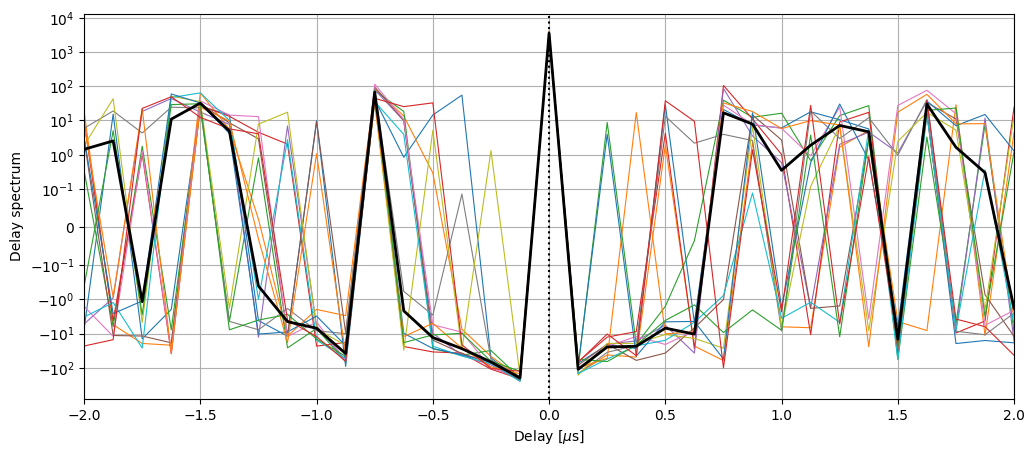

In [200]:
plt.figure(figsize=(12, 5))
plt.grid()
for i in range(uvp.Ntimes):
    plt.plot(uvp.dly_array*1e6, uvp.data_array[spw][i, :, 0].real, lw=.8)
plt.plot(uvp.dly_array*1e6, uvp_time_avg.data_array[spw][0, :, 0].real, color='k', lw=2, label='Time average')
plt.yscale('symlog', linthresh=1e-1)
plt.axvline(0, color='k', ls=':')
plt.xlabel(r'Delay [$\mu$s]')
plt.ylabel('Delay spectrum')
plt.xlim(-2, 2)

## Compute cylindrical power spectrum

In [229]:
cosmo = hp.conversions.Cosmo_Conversions()

In [235]:
spw_range = (100, 200)
avg_z = cosmo.f2z(np.mean(uvd_meta.freq_array[slice(*spw_range)]))    
print(f'Average redshift: {avg_z:.2f}')

Average redshift: 6.93


In [211]:
uvd = pyuvdata.UVData()
uvd.read_uvfits(datafile, polarizations=[pol])

In [212]:
# get redundant baselines
reds, lens, angs = hp.utils.get_reds(uvd, pick_data_ants=True)

In [248]:
bls1, bls2, blps, xants1, xants2, red_groups, red_lens, red_angs = hp.utils.calc_blpair_reds(
    uvd, uvd,
    exclude_auto_bls=True, exclude_permutations=True,
    bl_tol=1.0,
    extra_info=True
)
# bls1, bls2, blps = hp.utils.construct_blpairs(uvd_meta.get_antpairs(), exclude_auto_bls=True, exclude_permutations=False)

Text(0.5, 0, '$k_\\perp [$h$Mpc^{-1}]$')

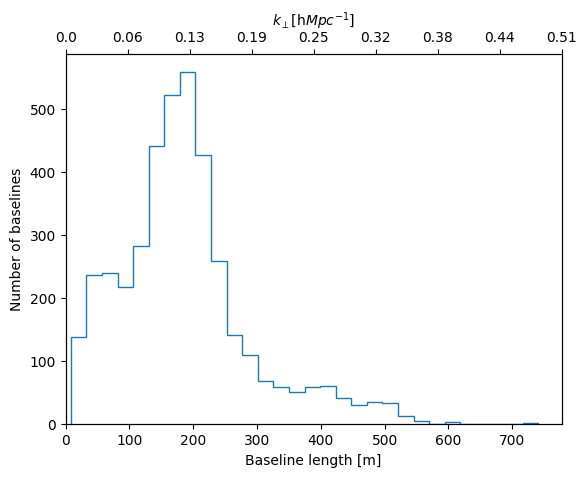

In [249]:
fig, ax = plt.subplots()
_ = ax.hist(red_lens, histtype='step', bins=30, lw=2.)
ax.set_xlabel('Baseline length [m]')
ax.set_xlim(left=0)
ax.set_ylabel('Number of baselines')
ax2 = ax.twiny()
ax2.set_xticks(ax.get_xticks(), labels=np.round(cosmo.bl_to_kperp(avg_z, little_h=True)*ax.get_xticks(), decimals=2))
ax2.set_xlabel(r'$k_\perp [$h$Mpc^{-1}]$')


In [250]:
# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd, uvd], wgts=[None, None], beam=uvb)
# ds.rephase_to_dset(0)
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'


In [251]:
# build ps
uvp = ds.pspec(
    bls1, bls2,
    dsets=(0, 1), 
    pols=[(pol, pol)],
    spw_ranges=[(100, 200)],  # select a smaller bandwidth
    verbose=False
)

blpair ((np.int32(4), np.int32(22)), (np.int32(9), np.int32(11))) exceeds redundancy tolerance of 1.0 m
blpair ((np.int32(9), np.int32(11)), (np.int32(23), np.int32(24))) exceeds redundancy tolerance of 1.0 m
blpair ((np.int32(9), np.int32(11)), (np.int32(25), np.int32(26))) exceeds redundancy tolerance of 1.0 m
blpair ((np.int32(23), np.int32(24)), (np.int32(25), np.int32(26))) exceeds redundancy tolerance of 1.0 m
blpair ((np.int32(12), np.int32(46)), (np.int32(39), np.int32(38))) exceeds redundancy tolerance of 1.0 m
blpair ((np.int32(21), np.int32(37)), (np.int32(52), np.int32(31))) exceeds redundancy tolerance of 1.0 m
blpair ((np.int32(23), np.int32(22)), (np.int32(52), np.int32(31))) exceeds redundancy tolerance of 1.0 m
blpair ((np.int32(37), np.int32(38)), (np.int32(45), np.int32(46))) exceeds redundancy tolerance of 1.0 m
blpair ((np.int32(4), np.int32(5)), (np.int32(20), np.int32(39))) exceeds redundancy tolerance of 1.0 m
blpair ((np.int32(4), np.int32(5)), (np.int32(43), n

Casting complex values to real discards the imaginary part


KeyboardInterrupt: 

In [ ]:
uvp_avg = uvp.average_spectra(blpair_groups=blpair_groups, time_avg=True, inplace=False)

In [ ]:
for redgroup in reds[:2]:
    # get baseline-pairs
    bls1, bls2, blps = hp.utils.construct_blpairs(redgroup, exclude_auto_bls=True, exclude_permutations=False)
    # Create a new PSpecData object, and don't forget to feed the beam object
    ds = hp.PSpecData(dsets=[uvd.select(antenna_nums=redgroup, inplace=False), uvd.select(antenna_nums=redgroup, inplace=False)], wgts=[None, None], beam=uvb)
    # ds.rephase_to_dset(0)
    ds.dsets[0].vis_units = 'mK'
    ds.dsets[1].vis_units = 'mK'
    # build ps
    uvp = ds.pspec(
        bls1, bls2,
        dsets=(0, 1), 
        pols=[(pol, pol)],
        spw_ranges=[(100, 200)],  # select a smaller bandwidth
        verbose=False
    )
    uvp.average_spectra(time_avg=True, inplace=False)

In [207]:
uvd.select(antenna_nums=redgroup)